# Causal Emergence - example usage

*Causal emergence* is when the coarse-grained network has more *effective information* ($EI$) than the micro-scale network. This means:

1. Calculate the $EI$ of the micro-scale network.
2. Propose a candidate micro-macro mapping and calculate its $EI$.
3. If $EI_{macro} > EI_{micro}$, accept the mapping.
4. Continue steps 2 & 3 until stop.

In [1]:
method_title = 'Causal Emergence Coarse Graining'

## Imports

In [2]:
import os
# If you are running this from ~/python_scripts/mycode.py
# change directory to the root of the repository
# All utils assume that the working directory is the root directory of the github folder
os.chdir('../') # ONLY DO ONCE!!!!

In [3]:
import sys
# Add utils directory in the list of directories to look for packages to import
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# local utils
from utils.causal_emergence import effective_information, causal_emergence, causal_emergence_spectral
from utils.mapping_auxiliary_functions import *
from utils.visualization_networkx import *

## Example (KC) with detailed information on the method

### Load graph

In [91]:
# make an example network
if True:
    # load karate club graph
    G_micro = G = nx.karate_club_graph()
else:
    # load graph from weighted edge list
    # weighted_edgelist = .......
    # G_micro = nx.from_pandas_edgelist(weighted_edgelist, edge_attr='weight') 
    # OR OTHER, e.g. from Ref [1] Yanghua Xiao, Ben D MacArthur, Hui Wang, Momiao Xiong, and Wei Wang. “Network quotients: Structural skeletons of complex systems”. In: Physical Review E 78.4 (2008), p. 046102. doi: 10.1103/PhysRevE.78.046102.
    G = nx.read_pajek('./data/PhD.paj')
    # some preprocessing
    G = G.to_undirected()
    nx.relabel_nodes(G, mapping={n:i for i,n in enumerate(G.nodes)},copy=False)
    for v in G.nodes:
        del G.nodes[v]['shape']

In [92]:
print("The effective information (EI) of G (microscale) is", effective_information(G))

The effective information (EI) of G (microscale) is 2.3766489441245473


### Run method

In [93]:
# Notice that for bigger networks, the spectral version works faster. In that case, use 
# mapping, weighted_edgelist = causal_emergence_spectral(G)

In [94]:
# the function causal_emergence returns the mapping of the nodes from microscale to macroscale as a table (pandas columns: micro, macro), and the weighted_edgelist as another table (pandas columns: )
mapping, weighted_edgelist = causal_emergence(G)
# CE = causal_emergence(G,dev=True) # to get more details
G_macro = nx.from_pandas_edgelist(weighted_edgelist, edge_attr='weight')

In [95]:
print("Microscale EI =",effective_information(G))
print("Macroscale EI =",effective_information(G_macro))

Microscale EI = 2.3766489441245473
Macroscale EI = 2.7530007994386283


In [96]:
print('Original number of nodes =', G.number_of_nodes())
print('Original number of edges =', G.number_of_edges())
print('Coarse-grained number of nodes =', G_macro.number_of_nodes())
print('Coarse-grained number of edges =', G_macro.number_of_edges())

Original number of nodes = 34
Original number of edges = 78
Coarse-grained number of nodes = 27
Coarse-grained number of edges = 62


### See output variables
(for reference of how your output should look like)

In [97]:
# If you're loading a vector of macro-mappings, assume that the index is the micro id
# You can transform the vector or the pandas dataframe into a dictionary with the functions in the util 'auxiliary_mapping_functions'

In [98]:
# Let's take a look at the resulting mapping. All values of size > largest node id are macronodes.
mapping

,micro,macro
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,35
8,8,8
9,9,9


In [99]:
weighted_edgelist

,source,target,weight
0,0,1,0.095238
1,0,2,0.119048
2,0,3,0.071429
3,0,4,0.071429
4,0,5,0.071429
...,...,...,...
118,35,2,0.200000
119,35,3,0.171429
120,35,33,0.114286
121,36,0,0.571429


### Visualization
This visualization shows the micro and macro networks side by side, with edge weidhts 

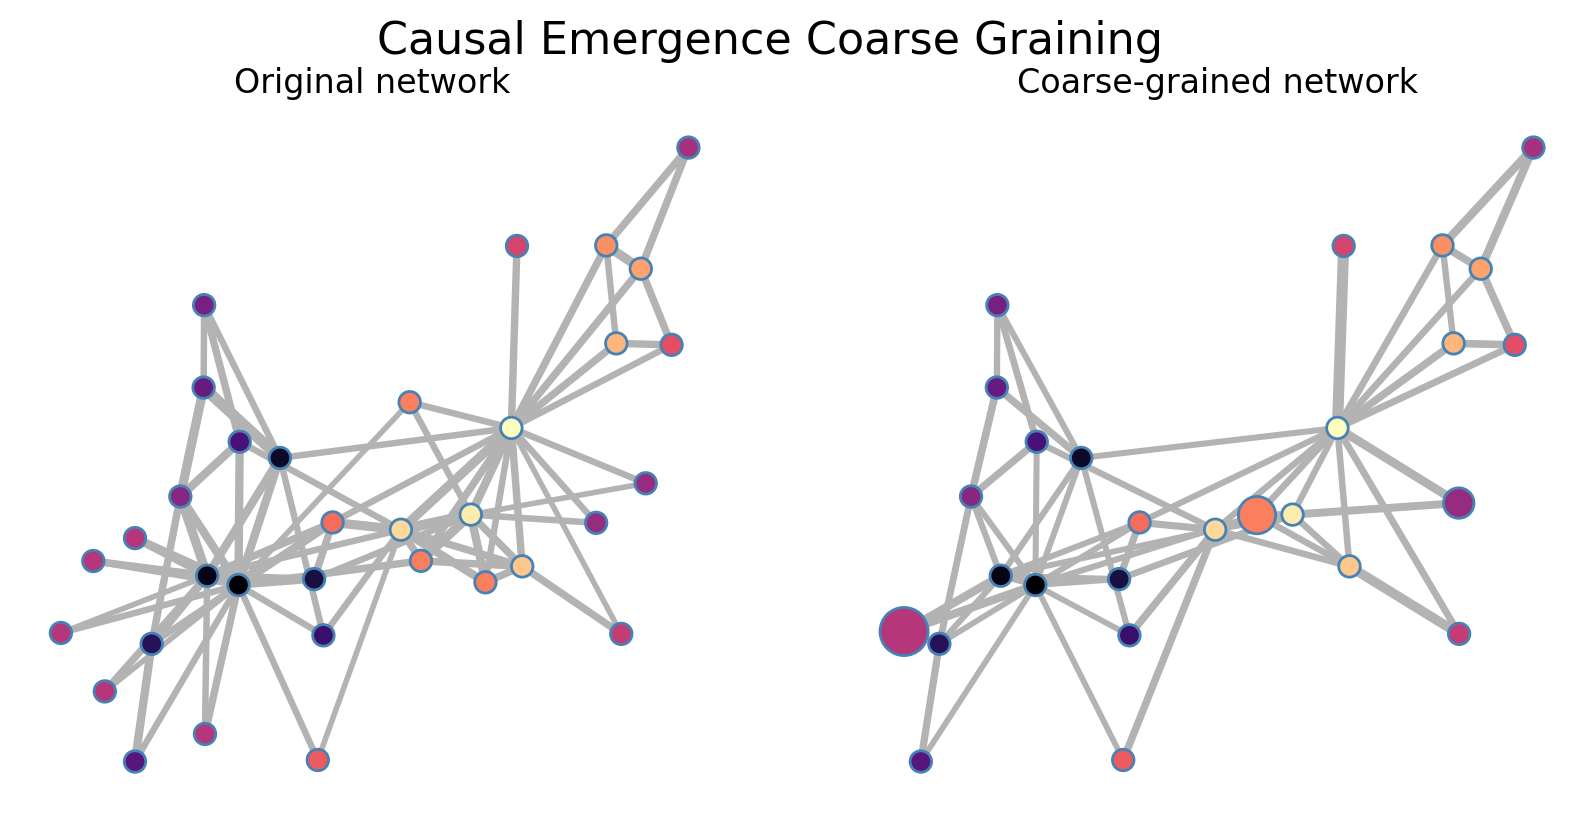

<Figure size 640x480 with 0 Axes>

In [100]:
visualize_micro_macro(G, mapping, G_macro, all_colorful = True, method_title=method_title, 
                      name_file = f'KC_colorful_{method_title}', file_format='png')

/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


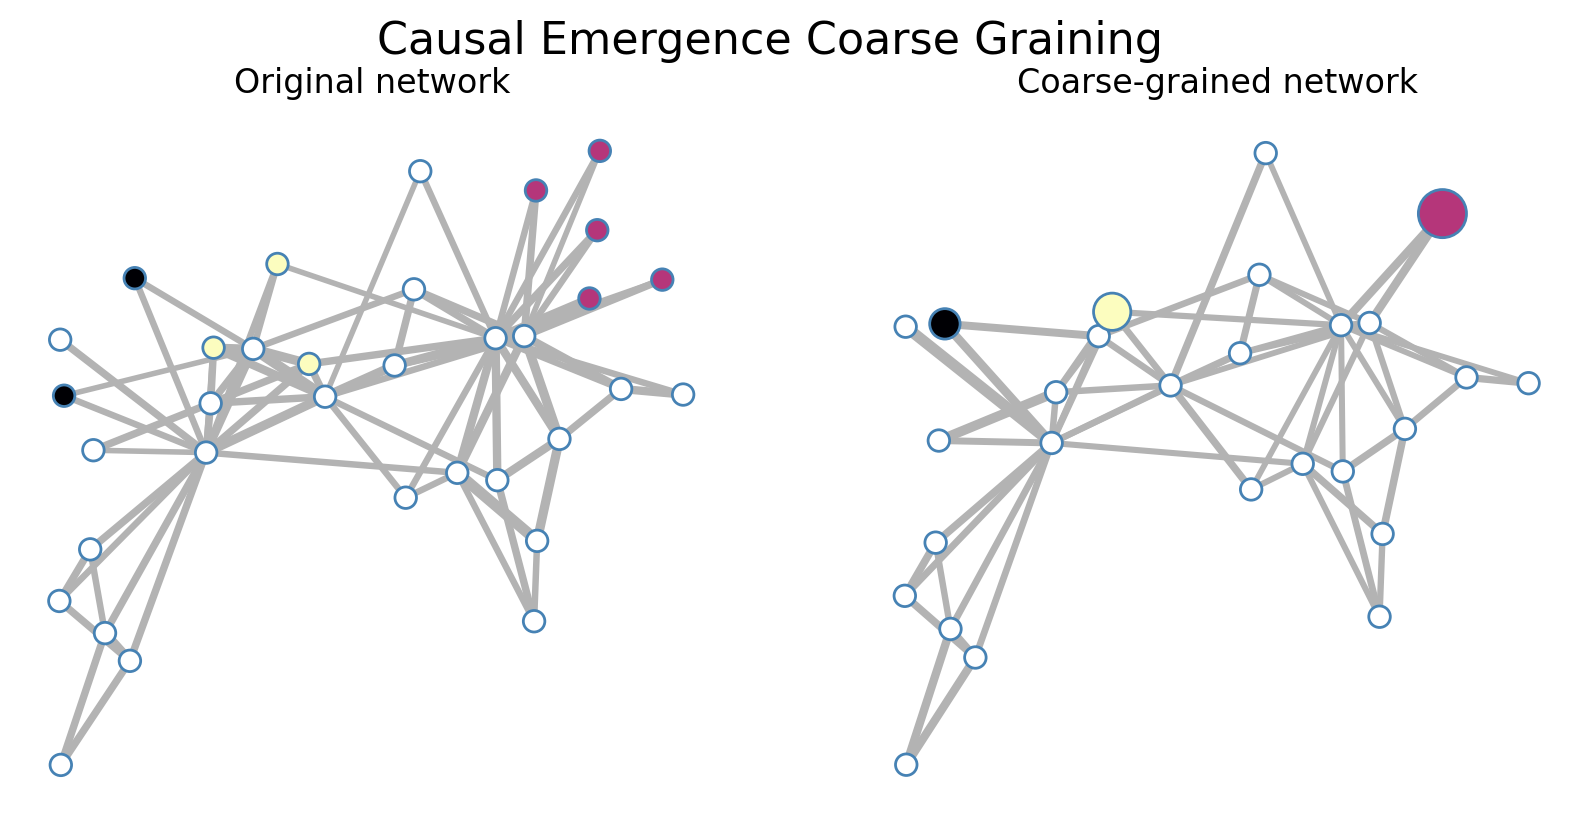

<Figure size 640x480 with 0 Axes>

In [101]:
visualize_micro_macro(G, mapping, G_macro, all_colorful = False, method_title=method_title, 
                      name_file = f'KC_{method_title}', file_format='png')

## Example with PhD data

In [41]:
# Data from Ref [1] Yanghua Xiao, Ben D MacArthur, Hui Wang, Momiao Xiong, and Wei Wang. “Network quotients: Structural skeletons of complex systems”. In: Physical Review E 78.4 (2008), p. 046102. doi: 10.1103/PhysRevE.78.046102.
G = nx.read_pajek('./data/PhD.paj')
# some preprocessing
G = nx.Graph(G)
nx.relabel_nodes(G, mapping={n:i for i,n in enumerate(G.nodes)},copy=False)
for v in G.nodes:
    del G.nodes[v]['shape']
    
print("Microscale EI =",effective_information(G))
print('Original number of nodes =', G.number_of_nodes())
print('Original number of edges =', G.number_of_edges())

Microscale EI = 7.826244287825251
Original number of nodes = 1024
Original number of edges = 1043


In [42]:
# the function causal_emergence returns the mapping of the nodes from microscale to macroscale as a table (pandas columns: micro, macro), and the weighted_edgelist as another table (pandas columns: )
mapping, weighted_edgelist = causal_emergence_spectral(G)

In [43]:
# CE = causal_emergence(G,dev=True)
G_macro = nx.from_pandas_edgelist(weighted_edgelist, edge_attr='weight')

In [44]:
print("Macroscale EI =",effective_information(G_macro))
print('Coarse-grained number of nodes =', G_macro.number_of_nodes())
print('Coarse-grained number of edges =', G_macro.number_of_edges())

Macroscale EI = 8.33021170876444
Coarse-grained number of nodes = 611
Coarse-grained number of edges = 630


/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


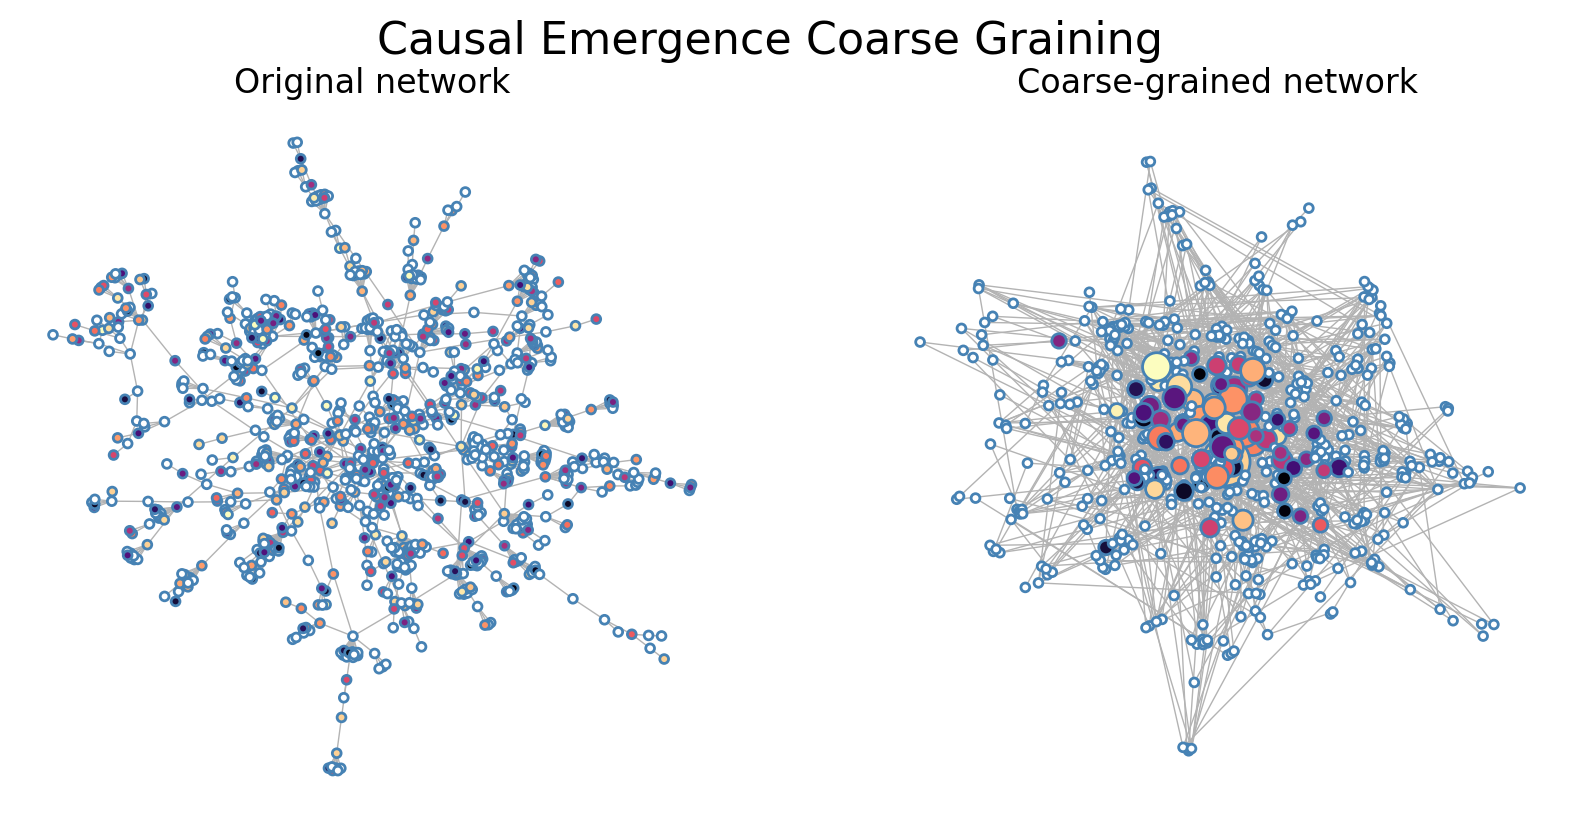

<Figure size 640x480 with 0 Axes>

In [75]:
visualize_micro_macro(G, mapping, G_macro, all_colorful = False, min_ns=10, min_lw=.5, max_lw = .5,
                      method_title=method_title, name_file = f'PHD_{method_title}', file_format='png')

## Example with ER_random
ER_random: N=1000, L=25087. Generated with the Erdos-Renyi ER(N,p) model, for N=1000 and p=0.05. Code: g_rand = nx.erdos_renyi_graph(1000, p = 0.05)

In [ ]:
G = nx.read_weighted_edgelist('./data/ER_random.edgelist', nodetype=int)

In [ ]:
print("Microscale EI =",effective_information(G))
print('Original number of nodes =', G.number_of_nodes())
print('Original number of edges =', G.number_of_edges())

In [ ]:
# the function causal_emergence returns the mapping of the nodes from microscale to macroscale as a table (pandas columns: micro, macro), and the weighted_edgelist as another table (pandas columns: )
mapping, weighted_edgelist = causal_emergence_spectral(G)

In [ ]:
# CE = causal_emergence(G,dev=True)
G_macro = nx.from_pandas_edgelist(weighted_edgelist, edge_attr='weight')

In [ ]:
print("Macroscale EI =",effective_information(G_macro))
print('Coarse-grained number of nodes =', G_macro.number_of_nodes())
print('Coarse-grained number of edges =', G_macro.number_of_edges())

In [ ]:
visualize_micro_macro(G, mapping, G_macro, all_colorful = False, #min_ns=10, min_lw=5, 
                      method_title=method_title, name_file = f'ER_random_{method_title}', file_format='png')

## Example with balanced tree
Balanced tree: N=1093, L=1092 with 3 children per node (branching factor = 3, Height of the tree = 6). Code: g_tree = nx.generators.balanced_tree(3,6)

In [126]:
G = nx.read_weighted_edgelist('./data/balanced_tree.edgelist', nodetype=int)

In [127]:
print("Microscale EI =",effective_information(G))
print('Original number of nodes =', G.number_of_nodes())
print('Original number of edges =', G.number_of_edges())

Microscale EI = 8.533170775576018
Original number of nodes = 1093
Original number of edges = 1092


In [ ]:
# the function causal_emergence returns the mapping of the nodes from microscale to macroscale as a table (pandas columns: micro, macro), and the weighted_edgelist as another table (pandas columns: )
mapping, weighted_edgelist = causal_emergence_spectral(G)

In [ ]:
# CE = causal_emergence(G,dev=True)
G_macro = nx.from_pandas_edgelist(weighted_edgelist, edge_attr='weight')

In [ ]:
print("Macroscale EI =",effective_information(G_macro))
print('Coarse-grained number of nodes =', G_macro.number_of_nodes())
print('Coarse-grained number of edges =', G_macro.number_of_edges())

In [ ]:
visualize_micro_macro(G, mapping, G_macro, all_colorful = False, #min_ns=10, min_lw=5, 
                      method_title=method_title, name_file = f'balanced_tree{method_title}', file_format='png')